## This jupyter notebook contains table creation in postgresql(PG) database,subsequent loading with data,data retrieving, deep dive in the data provided for Revolut challenge to do data preparation,feature engineering, exploratory analysis and build ML classification model to predict propensity to fraud in user level and action against each user. Throughout this notebook we will mainly do following task(Not always in the order):

### PART I - DATABASE operation
#### Input Data table creation and loading of data
#### Testing of data tables and accessing data from PG database


### PART II - EXPLORATION, ANALYSIS, MODELLING & OPERATIONALIZATION: 

- data preparation and feature engineering- I did it simultaneously, as the task demands
- Exploratory analysis of key(intuitive) features, visualization and some useful insights about fraudsters(Lot of things could     be done here with more time investment)
- Model data preparation(oversampling and variable transformation)for supervised ML model
- Feature Selection
- Final ML model building through Grid search(some feature related insights are also covered here)
- Model Evaluation and visualization
- Model operationalization with additional Model Evaluation points
- Some database operations of creating output and variable importance table and loading the data


### Assumptions

#### The frauds are happening in the user level, ie. the users are intentionally making frauds(someone who signs up and uses Revolut with the main goal of stealing other people's money into their account or other means).Here users(who are labeled as fraud) are not victim of frauds.
#### Frauds are detected as user level not in transaction level
#### Labeling as IS_FRAUDSTER is correct and exhaustive in 'users' data and these are the only fraudsters 

### Limitation

#### As user level fraud data is restricted to only no of users, who are common(intersection)in both 'users' and 'transactions' data.
#### With approximately 8k such user counts with highly imbalance data(event rate ~ 3.8%)the ML model performance is decent at most. Although with more time and research other techniques are worth trying.   


In [1424]:
#Packages
import psycopg2 as pg
import yaml
from pathlib import Path
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tqdm
import cv2
from scipy.spatial import distance
from PIL import Image
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict,cross_validate,GridSearchCV,RandomizedSearchCV
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF
import scipy
import datetime
import seaborn as sns
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import xgboost as xgb
from ctypes import *
from sklearn import datasets, metrics, model_selection
from sklearn.model_selection import cross_val_score, StratifiedKFold
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
import pickle
from itertools import cycle
from sklearn.metrics import roc_curve, auc,roc_auc_score,confusion_matrix,precision_recall_curve,f1_score,average_precision_score,accuracy_score,classification_report
from scipy import interp
from xgboost import plot_importance
import pickle

## PART I - DATABASE operation

### Connecting the postgresql(PG) database using my credentials

In [1479]:
#Database creation
try:
    connection = pg.connect(
    host= 'localhost',password = 'Data@12345',
    port=5432,
    dbname='revolute_challenge',
    user='postgres')
    print('data base is connected')
except:
    print('Database not connected')

data base is connected


### database operation functions

In [1480]:
#Functions for creating table

def create_tables(config, connection):
    cur = connection.cursor()
    for table in config:
        name = table.get('name')
        schema = table.get('schema')
        ddl = f"""CREATE TABLE IF NOT EXISTS {name} ({schema})"""
        cur.execute(ddl)
    connection.commit()

In [ ]:
#Functions for loading the tables with bulk data

def load_tables(config, connection,ip=True):
    """If ip==True it will load input data else it will load the model scored output data"""
    # iterate and load
    cur = connection.cursor()
    data_path_ip = "D:/data_science/revolut_challenge/data"     #Input data location
    data_path_op = "D:/data_science/revolut_challenge/deliverables/data"  #Output data location
    for table in config:
        table_name = table.get('name')
        if ip == True:
            table_source = os.path.join(data_path_ip,(f"{table_name}.csv"))
        else:
            table_source = os.path.join(data_path_op,(f"{table_name}.csv"))
        with open(table_source, 'r') as f:
            next(f)
            cur.copy_expert(f"COPY {table_name} FROM STDIN CSV NULL AS ''", f)
        connection.commit()

### ETL operation of loading of in input raw tables to PG

In [25]:
#creating and Loading the input raw tables 

with open("D:/data_science/revolut_challenge/misc/schemas.yaml") as schema_file:  #schema yaml for all Input tables
    config = yaml.load(schema_file)
create_tables(config, connection)
load_tables(config, connection,ip=True)

c:\users\sourish\anaconda3\lib\site-packages\ipykernel_launcher.py:4: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.



### Comparing data read from PG database and from local drive

In [35]:
#Testing wheather data loaded properly-Comparing no of rows for country table

try:
    cur = connection.cursor()
    cur.execute("""SELECT * FROM countries""") 
    rows = cur.fetchall()
    print('data reading')
except:
    print('data not read')
    
os.chdir('D:/data_science/revolut_challenge/data')    
country_drive = pd.read_csv('countries.csv')
country_pg=pd.DataFrame(rows,columns=country_drive.columns)
print('Data Read from local drive')
display(country_drive.head(5))
print('Data Read from Postgres DB-revolute_challenge')
display(country_drive.head(5))
if len(country_drive) == len(country_pg):
    print('Complete Data read')
else:
    print('Complete Data not read')

data reading
Data Read from local drive


,CODE,NAME,CODE3,NUMCODE,PHONECODE
0,AF,Afghanistan,AFG,4,93
1,AL,Albania,ALB,8,355
2,DZ,Algeria,DZA,12,213
3,AS,American Samoa,ASM,16,1684
4,AO,Angola,AGO,24,244


Data Read from Postgres DB-revolute_challenge


,CODE,NAME,CODE3,NUMCODE,PHONECODE
0,AF,Afghanistan,AFG,4,93
1,AL,Albania,ALB,8,355
2,DZ,Algeria,DZA,12,213
3,AS,American Samoa,ASM,16,1684
4,AO,Angola,AGO,24,244


Complete Data read


### Creating output(Patrol/user action)placeholder table to database to load data later 

In [ ]:
#creating output tables 

with open("D:/data_science/revolut_challenge/deliverables/output_schemas.yaml") as schema_file: #schema yaml for all Input tables
    config = yaml.load(schema_file)
create_tables(config, connection)
#load_tables(config, connection) #We will load these tables after task-2 completion

### Table read from database

In [1482]:
cur = connection.cursor()

#Users
cur.execute("Select * FROM users")
rows = cur.fetchall()
colnames = [desc[0] for desc in cur.description]
users = pd.DataFrame(rows)
users.columns = colnames
display(users.head(1))

#transactions
cur.execute("Select * FROM transactions")
rows = cur.fetchall()
colnames = [desc[0] for desc in cur.description]
transactions = pd.DataFrame(rows)
transactions.columns = colnames
display(transactions.head(1))

#currency_details
cur.execute("Select * FROM currency_details")
rows = cur.fetchall()
colnames = [desc[0] for desc in cur.description]
currency_details = pd.DataFrame(rows)
currency_details.columns = colnames
display(currency_details.head(1))

#countries
cur.execute("Select * FROM countries")
rows = cur.fetchall()
colnames = [desc[0] for desc in cur.description]
countries = pd.DataFrame(rows)
countries.columns = colnames
display(countries.head(1))

,id,has_email,phone_country,is_fraudster,terms_version,created_date,state,country,birth_year,kyc,failed_sign_in_attempts
0,1872820f-e3ac-4c02-bdc7-727897b60043,True,GB||JE||IM||GG,False,2018-05-25,2017-08-06 07:33:33.341,ACTIVE,GB,1971,PASSED,0


,currency,amount,state,created_date,merchant_category,merchant_country,entry_method,user_id,type,source,id,amount_usd
0,GBP,175,COMPLETED,2017-12-20 12:46:20.294,cafe,GBR,cont,8f99c254-7cf2-4e35-b7e4-53804d42445d,CARD_PAYMENT,GAIA,b3332e6f-7865-4d6e-b6a5-370bc75568d8,220


,ccy,exponent,is_crypto
0,AED,2,False


,code,name,code3,numcode,phonecode
0,AF,Afghanistan,AFG,4,93


#### Table read from drive

In [1484]:
os.chdir('D:/data_science/revolut_challenge/data')
users=pd.read_csv('users.csv')
transactions = pd.read_csv('transactions.csv')
fraudsters = pd.read_csv('fraudsters.csv')
currency_details = pd.read_csv('currency_details.csv')
countries = pd.read_csv('countries.csv')

### So All set for database creation,table creation,storing and retrieving data to and from PG database.

## Part-II-  Although through out the entire exercise there are few more database operations, now in rest of the Jupyter note-book we will focus on EXPLORATION, ANALYSIS, MODELLING & OPERATIONALIZATION user level fraud detection model

### Data preparation and feature engineering- 

#### -To prepare user level feature data we need to perform both these operations simultaneously. We will first create as many as features from transactions and other tables and then apply suitable feature selection technique. 

In [1485]:
print(transactions.shape)
print('transactions data has total %d unique users' %(len(np.unique(transactions.USER_ID))))
transactions

(688651, 12)
transactions data has total 8021 unique users


,CURRENCY,AMOUNT,STATE,CREATED_DATE,MERCHANT_CATEGORY,MERCHANT_COUNTRY,ENTRY_METHOD,USER_ID,TYPE,SOURCE,ID,AMOUNT_USD
0,GBP,175,COMPLETED,2017-12-20 12:46:20.294,cafe,GBR,cont,8f99c254-7cf2-4e35-b7e4-53804d42445d,CARD_PAYMENT,GAIA,b3332e6f-7865-4d6e-b6a5-370bc75568d8,220
1,EUR,2593,COMPLETED,2017-12-20 12:38:47.232,bar,AUS,cont,ed773c34-2b83-4f70-a691-6a7aa1cb9f11,CARD_PAYMENT,GAIA,853d9ff8-a007-40ef-91a2-7d81e29a309a,2885
2,EUR,1077,COMPLETED,2017-12-20 12:34:39.668,NaN,CZE,cont,eb349cc1-e986-4bf4-bb75-72280a7b8680,CARD_PAYMENT,GAIA,04de8238-7828-4e46-91f1-050a9aa7a9df,1198
3,GBP,198,COMPLETED,2017-12-20 12:45:50.555,supermarket,GBR,cont,dc78fbc4-c936-45d3-a813-e2477ac6d74b,CARD_PAYMENT,GAIA,2b790b9b-c312-4098-a4b3-4830fc8cda53,249
4,EUR,990,COMPLETED,2017-12-20 12:45:32.722,NaN,FRA,cont,32958a5c-2532-42f7-94f9-127f2a812a55,CARD_PAYMENT,GAIA,6469fc3a-e535-41e9-91b9-acb46d1cc65d,1101
5,EUR,2000,REVERTED,2017-12-20 12:44:14.216,NaN,NaN,misc,7a7ebaa8-6c24-4c4f-bb09-c30b3b98b73c,TOPUP,HERA,b074480b-d09b-40cb-aed3-e45039ae8e25,2225
6,GBP,300,COMPLETED,2017-12-20 12:44:10.132,NaN,GBR,chip,c069a845-b843-475e-af4f-a27e379f1c76,CARD_PAYMENT,GAIA,8c4328f3-5f39-4526-9ff8-cddb72cea623,378
7,EUR,1000,COMPLETED,2017-12-20 12:42:58.51,NaN,GRC,chip,f9588784-a994-4bfc-b4a0-d97f8c4941f7,CARD_PAYMENT,GAIA,f8bd44b7-a812-4468-9994-850d4dc1d0b0,1112
8,GBP,1000,COMPLETED,2017-12-20 12:42:52.014,NaN,NaN,misc,c248610a-3e08-4620-a6c3-89eb338fe155,TOPUP,HERA,1e819f57-8aed-4602-ae8f-58e1862836f0,1260
9,EUR,80,COMPLETED,2017-12-20 12:41:53.683,NaN,LTU,cont,a827cf38-cb43-46af-b728-413c313b5b6d,CARD_PAYMENT,GAIA,cabba07c-d0f1-474e-b3a3-53ed50e21c38,89


#### First to check and treat missing values if any 

In [360]:
def missing_quantity(data,column):
    missing = pd.DataFrame(data[column].apply(lambda x: np.sum(x.isnull(), axis=0)))
    missing['count_missing'] = missing.iloc[:,0]
    missing['percentage_missing'] = (missing.iloc[:,0]/data.shape[0])*100
    missing.drop(missing.columns[0],axis='columns',inplace=True)
    return(missing)
missing_quantity(transactions,transactions.columns)

,count_missing,percentage_missing
CURRENCY,0,0.000000
AMOUNT,0,0.000000
STATE,0,0.000000
CREATED_DATE,0,0.000000
MERCHANT_CATEGORY,465586,67.608411
MERCHANT_COUNTRY,205596,29.854890
ENTRY_METHOD,0,0.000000
USER_ID,0,0.000000
TYPE,0,0.000000
SOURCE,0,0.000000


In [430]:
transactions.MERCHANT_CATEGORY[transactions.MERCHANT_CATEGORY.isna()] = 'marchant_category_not_known'
transactions.MERCHANT_COUNTRY[transactions.MERCHANT_COUNTRY.isna()] = 'marchant_country_not_known'
missing_quantity(transactions,transactions.columns)

c:\users\sourish\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

c:\users\sourish\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,count_missing,percentage_missing
CURRENCY,0,0.0
AMOUNT,0,0.0
STATE,0,0.0
CREATED_DATE,0,0.0
MERCHANT_CATEGORY,0,0.0
MERCHANT_COUNTRY,0,0.0
ENTRY_METHOD,0,0.0
USER_ID,0,0.0
TYPE,0,0.0
SOURCE,0,0.0


### Now we got rid of missing values/NULLs

### Now as next step we will create user level transactional features for all the fields in transactions data. May be there are redundant/useless features, but later we will select best out of them through suitable feature selection technique. 

#### - The rationale behind making this feature engineering is to understand transaction pattern of users to capture user behaviour. As it's user created intentional fraud there must be a multivariate combination(eg a typical distribution of no of currency used and merchant category with a country combination) of  of transactional features,which has more likelihood of fraudulent characteristics than others.

#### - Even for user level fraud detection, we need to keep in mind that a particular fraud incident happens in transactional level.

#### - There will be creation of sparse matrices,so there are many NaNs as feature values for users. This is normal as there will not be transaction for each user for every subcategory of a feature.So it is logical to impute these NaNs with zero. For illustration purpose here I used same feature creation and 'fillna' operation for each feature.Later during train.py script I will do it at once in a data preparation function block.

In [364]:
#Currency_type

currency_type = pd.DataFrame(pd.pivot_table(transactions[['USER_ID','CURRENCY']],index=['USER_ID'],columns='CURRENCY', aggfunc = np.count_nonzero)).reset_index(drop=True)
currency_type.fillna(0, inplace=True)
currency_type['count_diff_currency']=[np.count_nonzero(np.array(currency_type.iloc[i,:])) for i in range(currency_type.shape[0])]
currency_type.head(2)

CURRENCY,AED,AUD,BTC,CAD,CHF,CZK,DKK,ETH,EUR,GBP,...,QAR,RON,SEK,SGD,THB,TRY,USD,XRP,ZAR,count_diff_currency
0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,22.0,0.0,0.0,2


In [112]:
#Currency_amount
currency_amount = pd.DataFrame(pd.pivot_table(transactions[['USER_ID','CURRENCY','AMOUNT']],index=['USER_ID'],columns='CURRENCY',values = 'AMOUNT', aggfunc = np.sum)).reset_index(drop=True)
currency_amount.fillna(0, inplace=True)
def renaming_fun(x):
    return '_'.join([x,'amt'])
currency_amount.columns = [renaming_fun(col) for col in list(currency_amount.columns)]
currency_amount.head(2)

,AED_amt,AUD_amt,BTC_amt,CAD_amt,CHF_amt,CZK_amt,DKK_amt,ETH_amt,EUR_amt,GBP_amt,...,PLN_amt,QAR_amt,RON_amt,SEK_amt,SGD_amt,THB_amt,TRY_amt,USD_amt,XRP_amt,ZAR_amt
0,0.0,0.0,0.0,0.0,0.0,0.0,251765.0,0.0,980.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,149811.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57618.0,0.0,0.0


In [138]:
#STATE

state = pd.DataFrame(pd.pivot_table(transactions[['USER_ID','STATE']],index=['USER_ID'],columns='STATE', aggfunc = np.count_nonzero))
user_id = pd.DataFrame(state.index)
state.fillna(0, inplace=True)
state.head(2)

STATE,CANCELLED,COMPLETED,DECLINED,FAILED,PENDING,RECORDED,REVERTED
USER_ID,,,,,,,
000e88bb-d302-4fdc-b757-2b1a2c33e7d6,0.0,24.0,0.0,0.0,0.0,0.0,8.0
001032e0-8071-4baf-95b9-e50214665c2e,0.0,62.0,4.0,0.0,0.0,0.0,6.0


In [431]:
#MERCHANT_CATEGORY

MERCHANT_CATEGORY = pd.DataFrame(pd.pivot_table(transactions[['USER_ID','MERCHANT_CATEGORY']],index=['USER_ID'],columns='MERCHANT_CATEGORY', aggfunc = np.count_nonzero)).reset_index(drop=True)
MERCHANT_CATEGORY.fillna(0, inplace=True)
MERCHANT_CATEGORY['count_diff_marchants']=[np.count_nonzero(np.array(MERCHANT_CATEGORY.iloc[i,:])) for i in range(MERCHANT_CATEGORY.shape[0])]
MERCHANT_CATEGORY.head(2)

MERCHANT_CATEGORY,accounting,administrative_area_level_1,administrative_area_level_2,administrative_area_level_3,administrative_area_level_4,airport,amusement_park,aquarium,archipelago,art_gallery,...,subway_station,supermarket,taxi_stand,train_station,transit_station,travel_agency,university,veterinary_care,zoo,count_diff_marchants
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6


In [862]:
##MERCHANT_COUNTRY

MERCHANT_COUNTRY = pd.DataFrame(pd.pivot_table(transactions[['USER_ID','MERCHANT_COUNTRY']],index=['USER_ID'],columns='MERCHANT_COUNTRY', aggfunc = np.count_nonzero)).reset_index(drop=True)
MERCHANT_COUNTRY.fillna(0, inplace=True)
def renaming_fun(x):
    return '_'.join(['country',x])
MERCHANT_COUNTRY.columns = [renaming_fun(col) for col in list(MERCHANT_COUNTRY.columns)]
MERCHANT_COUNTRY['count_diff_marchants_country']=[np.count_nonzero(np.array(MERCHANT_COUNTRY.iloc[i,:])) for i in range(MERCHANT_COUNTRY.shape[0])]
MERCHANT_COUNTRY.head(2)

,country_000,country_001,country_003,country_004,country_005,country_006,country_007,country_008,country_009,country_011,...,country_VNM,country_W71,country_WA,country_XXX,country_ZAF,country_ZHE,country_ZMB,country_ZWE,country_marchant_country_not_known,count_diff_marchants_country
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,2
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,4


In [137]:
#ENTRY_METHOD

ENTRY_METHOD = pd.DataFrame(pd.pivot_table(transactions[['USER_ID','ENTRY_METHOD']],index=['USER_ID'],columns='ENTRY_METHOD', aggfunc = np.count_nonzero))
ENTRY_METHOD.fillna(0, inplace=True)
ENTRY_METHOD.head(2)

ENTRY_METHOD,chip,cont,mags,manu,mcon,misc
USER_ID,,,,,,
000e88bb-d302-4fdc-b757-2b1a2c33e7d6,0.0,16.0,0.0,0.0,0.0,16.0
001032e0-8071-4baf-95b9-e50214665c2e,24.0,12.0,10.0,4.0,0.0,22.0


In [140]:
##TYPE

TYPE = pd.DataFrame(pd.pivot_table(transactions[['USER_ID','TYPE']],index=['USER_ID'],columns='TYPE', aggfunc = np.count_nonzero)).reset_index(drop=True)
TYPE.fillna(0, inplace=True)
TYPE['count_diff_type']=[np.count_nonzero(np.array(TYPE.iloc[i,:])) for i in range(TYPE.shape[0])]
TYPE.head(2)

TYPE,ATM,BANK_TRANSFER,CARD_PAYMENT,P2P,TOPUP,count_diff_type
0,0.0,2.0,16.0,4.0,10.0,4
1,4.0,0.0,46.0,0.0,22.0,3


In [141]:
##Source

SOURCE = pd.DataFrame(pd.pivot_table(transactions[['USER_ID','SOURCE']],index=['USER_ID'],columns='SOURCE', aggfunc = np.count_nonzero)).reset_index(drop=True)
SOURCE.fillna(0, inplace=True)
SOURCE['count_diff_SOURCE']=[np.count_nonzero(np.array(SOURCE.iloc[i,:])) for i in range(SOURCE.shape[0])]
SOURCE.head(2)

SOURCE,APOLLO,BRIZO,CRONUS,GAIA,HERA,INTERNAL,LETO,LIMOS,MINOS,NYX,OPHION,count_diff_SOURCE
0,0.0,0.0,2.0,16.0,10.0,4.0,0.0,0.0,0.0,0.0,0.0,4
1,0.0,0.0,0.0,50.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,2


#### The feature of the currency(especially the currency has 'IS_CRYPTO' feature or not)used by users also might be useful to understand how the users like to transact

In [414]:
#currency_details
display(currency_details.head(5))
currency_details.IS_CRYPTO.value_counts()

,CCY,EXPONENT,IS_CRYPTO
0,AED,2,False
1,AFN,2,False
2,ALL,2,False
3,AMD,2,False
4,ANG,2,False


False    179
True       5
Name: IS_CRYPTO, dtype: int64

#### Further feature Engineering

In [424]:
#Crypto
transactions = pd.merge(transactions,currency_details[['CCY','IS_CRYPTO']],how='left',left_on='CURRENCY',right_on='CCY')
IS_CRYPTO = pd.DataFrame(pd.pivot_table(transactions[['USER_ID','IS_CRYPTO']],index=['USER_ID'],columns='IS_CRYPTO', aggfunc = np.count_nonzero)).reset_index(drop = True)
IS_CRYPTO.fillna(0, inplace=True)
IS_CRYPTO.columns = ['not_crypto','crypto']
IS_CRYPTO['is_crypto'] = [1 if IS_CRYPTO.crypto[i] > 0 else 0 for i in range(IS_CRYPTO.shape[0])]
IS_CRYPTO.head(2)

,not_crypto,crypto,is_crypto
0,16.0,0.0,0
1,36.0,0.0,0


#### At last we create user level data merging all the created features.

In [1356]:
#userlevel Data prep 

user_level_data = pd.concat([user_id,currency_type,currency_amount,ENTRY_METHOD,TYPE,SOURCE,IS_CRYPTO,MERCHANT_CATEGORY,MERCHANT_COUNTRY],axis=1)
display(user_level_data.head(2))
user_level_data.shape

,USER_ID,AED,AUD,BTC,CAD,CHF,CZK,DKK,ETH,EUR,...,country_VNM,country_W71,country_WA,country_XXX,country_ZAF,country_ZHE,country_ZMB,country_ZWE,country_marchant_country_not_known,count_diff_marchants_country
0,000e88bb-d302-4fdc-b757-2b1a2c33e7d6,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,2
1,001032e0-8071-4baf-95b9-e50214665c2e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,4


(8021, 550)

### There are a few user specific features, such as age,app_version and other derived features might be critical to assess the users

#### - Currently these are all hypothesis(which will be tested through suitable feature selection algorithm) and might be weak signal.However for ML model each feature has incremental value,as long as there is no perfect multilcolinearity. 

In [1357]:
#user level features

user_level_data = pd.merge(user_level_data,users,how='inner',left_on='USER_ID',right_on='ID')
#User age during creation
user_level_data['age'] = pd.Series(user_level_data['CREATED_DATE'].apply(lambda x: str(x).split('-')[0])).astype('int')-user_level_data['BIRTH_YEAR'].astype('int')

#Flag for country and PHONE_COUNTRY different
user_level_data['user_different_PHONE_COUNTRY'] = (np.array([str(user_level_data['COUNTRY'][i]) not in str(user_level_data['PHONE_COUNTRY'][i]) for i in range(len(user_level_data))])).astype('int32') 

#TERMS_VERSION using(yearwise)
user_level_data['TERMS_VERSION'] = pd.Series(user_level_data['TERMS_VERSION'].apply(lambda x: str(x).split('-')[0]))
user_level_data['TERMS_VERSION'][user_level_data['TERMS_VERSION'] == 'nan'] = 'version_not_known'

#Signing attempt failed flag
#user_level_data['is_signing_attempt_failed'] = np.array([str(user_level_data['FAILED_SIGN_IN_ATTEMPTS'][i]) > 0 for i in range(len(user_level_data))]).astype('int32') 

#Droping redundant columns
user_id = user_level_data['USER_ID']
user_level_data.drop(['USER_ID','PHONE_COUNTRY','STATE','CREATED_DATE', 'COUNTRY', 'BIRTH_YEAR','ID'], axis = 1, inplace=True)
user_level_data.shape

c:\users\sourish\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



(7748, 556)

### Exploratory data analysis, visualization and insights- 

#### -Next we will see a few characteristics of fraudsters.

#### -To respect time, I will analyse few importantant or intuitive features. However a lot can be done here as full scale project.

In [1487]:
#Missing value check at final data

missing = missing_quantity(user_level_data,user_level_data.columns)
np.sum(missing['count_missing']) 

0

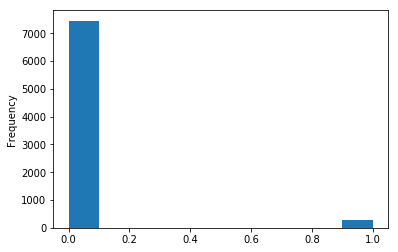

,IS_FRAUDSTER,percent
False,7451,0.961668
True,297,0.038332


In [369]:
#'IS_FRAUDSTER' univariate analysis

user_level_data['IS_FRAUDSTER'].astype(int).plot.hist()
plt.show()
t = pd.DataFrame(user_level_data['IS_FRAUDSTER'].value_counts())
t['percent'] = t['IS_FRAUDSTER']/t['IS_FRAUDSTER'].sum()
t

#### As expected the data is extremely imbalanced as the fraud is a rare event.We need to strategise how to handle this during modelling. 

#### Next we will analyse(bivariate analysis) a few key categorical features,intuitively may distinguise fraudsters.

This EDA is for HAS_EMAIL


HAS_EMAIL,0,1
0,0.003876,0.039519


1    7490
0     258
Name: HAS_EMAIL, dtype: int64

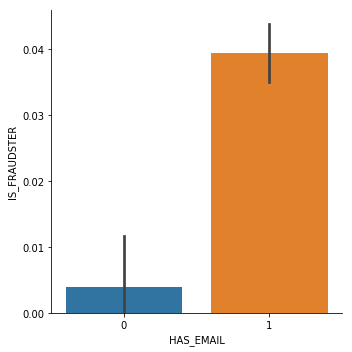

This EDA is for TERMS_VERSION


TERMS_VERSION,2017,2018,version_not_known
0,0.055172,0.033185,0.074745


2018                 6720
version_not_known     883
2017                  145
Name: TERMS_VERSION, dtype: int64

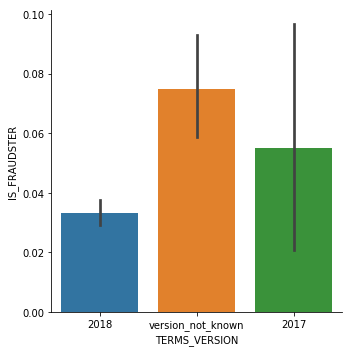

This EDA is for KYC


KYC,FAILED,NONE,PASSED,PENDING
0,0.09205,0.0,0.038111,0.262295


PASSED     6796
NONE        652
FAILED      239
PENDING      61
Name: KYC, dtype: int64

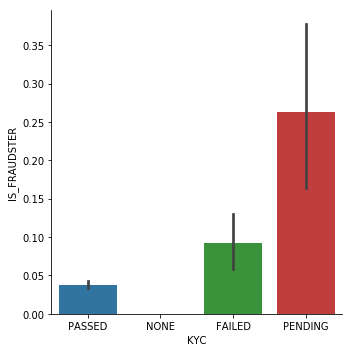

This EDA is for FAILED_SIGN_IN_ATTEMPTS


FAILED_SIGN_IN_ATTEMPTS,0,1,2,3,6
0,0.038167,0.045455,0.105263,0.0,0.0


0    7703
1      22
2      19
3       3
6       1
Name: FAILED_SIGN_IN_ATTEMPTS, dtype: int64

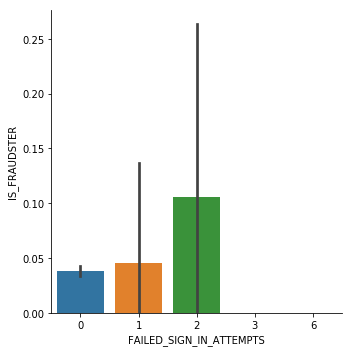

This EDA is for user_different_PHONE_COUNTRY


user_different_PHONE_COUNTRY,0,1
0,0.038741,0.028662


0    7434
1     314
Name: user_different_PHONE_COUNTRY, dtype: int64

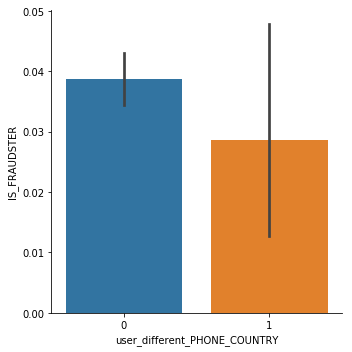

This EDA is for is_crypto


is_crypto,0,1
0,0.03876,0.014599


0    7611
1     137
Name: is_crypto, dtype: int64

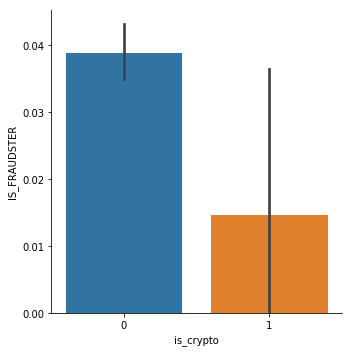

In [1324]:
#EDA and visualization for Categorical feature

cols = ['HAS_EMAIL','TERMS_VERSION','KYC','FAILED_SIGN_IN_ATTEMPTS','user_different_PHONE_COUNTRY','is_crypto']

for i in cols:
    print('This EDA is for %s' %(i))
    display(pd.DataFrame(pd.pivot_table(user_level_data[['IS_FRAUDSTER',i]],columns=i,values=i, aggfunc = np.mean)).reset_index(drop=True))
    display(user_level_data[i].value_counts())
    sns.catplot(x=i, y="IS_FRAUDSTER", kind="bar", data=user_level_data)
    plt.show()

#### From the bivariate EDA and bar plots it's visible that 'TERMS_VERSION' palays a critical role in triggering fraudulent behaviour.Latest term- 2018 has relatively less(40%) event rate(fraud rate)than its older version.Also the for the users 'version_not_known' have 2.25 times higher event rate than 2018 versions. This is probably because of the stricter regulation and monitoring for the latest version. Although these two categories are minority in counts compared to 2018, it has major impact for this rare event scenario to calculate propensity to fraud.It will definitely come out as a important feature.

#### Also as expected 'FAILED_SIGN_IN_ATTEMPTS' depicts user behaviour with more nos of failed signing attempts triggers higher fraud rate.Even majority have 0 FAILED_SIGN_IN_ATTEMPTS, if we create a flag 0 vs. non-zero FAILED_SIGN_IN_ATTEMPTS,using only this feature we can detect 3(~1%) fraudsters in this small dataset.

#### Similarly KYC 'failed' and 'pending' customers has more propensity to make fraud 2.4 times and 6.9 times than KYC PASSED resp. Although with very low representation for these categories compared to PASSED, for this grossly imbalanced data it's critical.However I have a fundamental question: "How before KYC passed, users can use their cards"?

#### Counter-intuitively the users used crypto currency at least one has 62% less fraud rate, who didn't use.Even with very low no with crypto currency, this feature may worth exploring.

#### Also 'HAS_EMAIL' and 'user_different_PHONE_COUNTRY'(user's country and phone country is different)binary features have some discriminatory power, however minority one sub-category be. 

This plot is for age


IS_FRAUDSTER,0,1
0,34.106831,30.289562


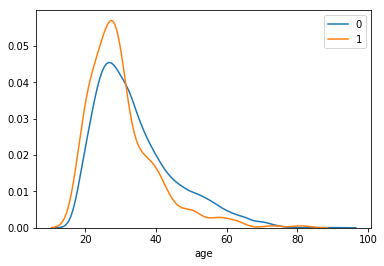

This plot is for count_diff_marchants_country


IS_FRAUDSTER,0,1
0,4.267347,4.023569


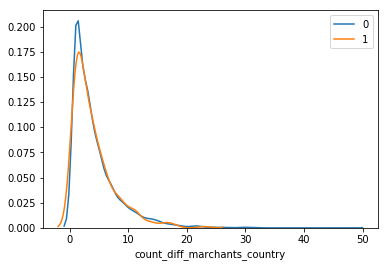

This plot is for count_diff_marchants


IS_FRAUDSTER,0,1
0,6.712119,6.309764


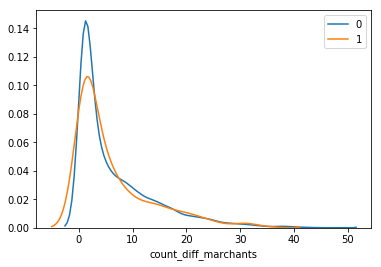

This plot is for marchant_category_not_known


IS_FRAUDSTER,0,1
0,116.28882,104.087542


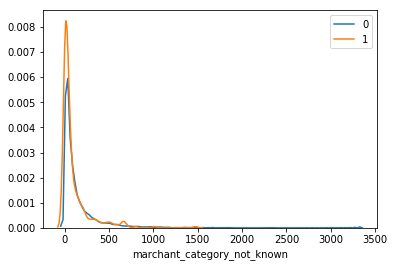

This plot is for count_diff_currency


IS_FRAUDSTER,0,1
0,1.663535,1.622896


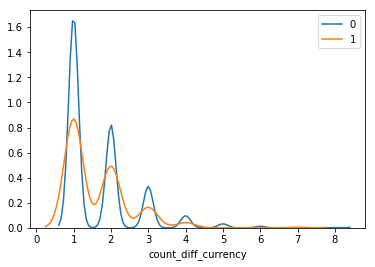

This plot is for marchant_country_not_known


IS_FRAUDSTER,0,1
0,51.170313,49.158249


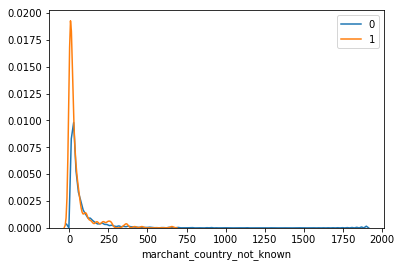

In [507]:
##EDA and visualization for continuous features

continuous = ['age','count_diff_marchants_country','count_diff_marchants','marchant_category_not_known','count_diff_currency','marchant_country_not_known']

for i in continuous:
    print('This plot is for %s' %(i))
    display(pd.DataFrame(pd.pivot_table(user_level_data[['IS_FRAUDSTER',i]],columns='IS_FRAUDSTER',values=i, aggfunc = np.mean)).reset_index(drop=True))
    for target in targets:
        sns.distplot(user_level_data[(user_level_data['IS_FRAUDSTER'] == target)][i], hist=False, rug=False,label=target)
    plt.show() 

#### The distribution and EDA of user age for fraudulent vs. non-fraudulent, it's clearly evident that fraudsters' average is less than that of non-fraudsters' and this will come out as one of the most important features. This is natural and intuitive for any risk models, such as default, fraud,AML etc.

#### For other continuous variables, although there is no apparent pattern, for non-linear ML algorithm these may add incremental value and atleast worth taking in the filtering process of feature selection algorithm.

### Next we will explore one multivariate(more one independent feature)space to understand fraudulent pattern

#### For sake of time I explored only one such significant pocket, however more are worth exploring.

this analysis is for KYC and TERMS_VERSION multivariate space


KYC,FAILED,NONE,PASSED,PENDING
TERMS_VERSION,,,,
2017,0.000000,0.0,0.061224,0.666667
2018,0.082803,0.0,0.031983,0.250000
version_not_known,0.128571,0.0,0.113445,0.214286


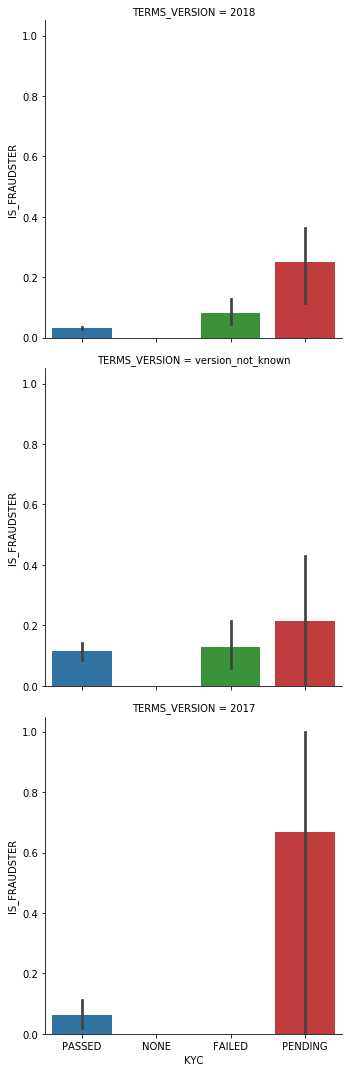

In [497]:
#Analysis in Mutivariate space

def multivar_analysis(data,x,y,index):
    print('this analysis is for %s and %s multivariate space' %(x, index))
    display((pd.pivot_table(data[[y,x,index]],index=index,columns=x,values=y,aggfunc = np.mean)))
    sns.catplot(x=x, y=y, row=index,label=y,
                kind="bar",
                data=data)
    plt.show()  

multivar_analysis(data=user_level_data,x='KYC',y='IS_FRAUDSTER',index='TERMS_VERSION') 

#### So from the all the combination of two independent features - 'TERMS_VERSION' and 'KYC' in Multivariate space we see that a certain combination of values(KYC='Pending' and TERMS_VERSION = '2017') generates humongous higher(>20 times) event rate than a ideal KYC status('Passed')with latest app version(2018).Although minuscule/rare in frequency rather rare, fraud detection process falls in the regime of anomaly detection. Also for the combination of values for KYC= 'Pending'/'Failed' and has TERMS_VERSION =  'version_not_known' or 2017 have relatively higher event rate than ideal candidates(KYC status ='Passed' with version 2018)

#### This is just a illustration a simple linear Multivariate space(only with 2 features) analysis,as built in feature the ML algorithm will fit the event in hundreds of complex non-linear Multivariate space and will add lot more distinctive power to calculate fraud propensity.  

### Feature Transformation
#### - We have dependent variable- 'IS_FRAUDSTER' and independent features- 'KYC' and 'TERMS_VERSION' as categorical. For ML model we need to make suitable transformation,so that algorithm can treat them accordingly.

#### -We created a class category 'cat_data_transform', which can take care of relevant feature transformation- LabelEncoding('IS_FRAUDSTER') and OneHotEncoding('KYC' and 'TERMS_VERSION'). Also we create provision for inverse transform of these Encodings.

In [262]:
#Data Transformation

class cat_data_transform():
    def __init__(self):
        self.le = LabelEncoder()
        self.oe = OneHotEncoder(sparse = False)
    def onehot_encode(self,x):
        feature = self.le.fit_transform(x)
        self.oe = OneHotEncoder(sparse = False)
        return self.oe.fit_transform(feature.reshape(-1,1))
    def label_encode(self,x):
        return self.le.fit_transform(x)
    def inverse_enc(self,x):
        inv = list()
        for i in range(len(x)):
            inv.append(np.argmax(x[i]))
        inv=np.array(inv)    
        return self.le.inverse_transform(inv)

In [1358]:
user_level_data['IS_FRAUDSTER'] = cat.label_encode(user_level_data['IS_FRAUDSTER'])
enc_kyc = pd.DataFrame(cat.onehot_encode(user_level_data['KYC']),columns=['FAILED','NONE','PASSED','PENDING'])
enc_version = pd.DataFrame(cat.onehot_encode(user_level_data['TERMS_VERSION']),columns=['2017_version','2018_version','version_not_known'])
user_level_data.drop(['KYC','TERMS_VERSION'],axis=1,inplace=True)
model_data = pd.concat([user_level_data,enc_kyc,enc_version],axis=1)
model_data.shape

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this

(7748, 561)

### Before building ML model we need to keep in mind that the data is extremely imbalanced. 

#### - So treat this data anomaly,before building model we have a few strategies, which will be applied only on training data, NOT ON VALIDATION DATA.So a re-producible data splitting is first required.

In [1359]:
train_X,valid_X,train_Y,valid_Y = train_test_split(model_data.iloc[:,model_data.columns!='IS_FRAUDSTER'],model_data.iloc[:,model_data.columns=='IS_FRAUDSTER'],test_size = 0.1, random_state = 20)
user_train,user_valid = train_test_split(user_id,test_size = 0.1, random_state = 20)
t = pd.DataFrame(train_Y['IS_FRAUDSTER'].value_counts())
t['percent'] = t['IS_FRAUDSTER']/t['IS_FRAUDSTER'].sum()
v = pd.DataFrame(valid_Y['IS_FRAUDSTER'].value_counts())
v['percent'] = v['IS_FRAUDSTER']/v['IS_FRAUDSTER'].sum()
print('training label stat')
print(t)
print('validation label stat')
print(v)

training label stat
   IS_FRAUDSTER   percent
0          6706  0.961709
1           267  0.038291
validation label stat
   IS_FRAUDSTER  percent
0           745  0.96129
1            30  0.03871


### Plain vanilla supervised learning will result in putting much higher importance to the non-fraudsters, as even with predicting every user as non-fraudster, model can achieve > 96% accuracy and 100% Specificity. However our goal here to reduce false negative(FN) as much as possible even with slight deterioration of accuracy.

#### To treat this anomaly/imbalance class problem, we have following few strategies. 
##### - Resampling- Oversampling of minority class and or Under sampling of minority class,Resample with different ratios,Ensemble different resampled datasets etc.
##### - SMOTE(Synthetic Minority Over-sampling Technique), which creates synthetic data with minority class using KNN(K-Nearest Neighbours)algorithm.
##### - Weight correction(Putting proportional weights to minority class)

#### For sake of time I tried only SMOTE and Weight correction(for final model)

#### SMOTE- We applied this only on the training data sample

In [1360]:
print("Before OverSampling, counts of label FRAUDSTER : {}".format(sum(np.array(train_Y==1))))
print("Before OverSampling, counts of label not_FRAUDSTER: {} \n".format(sum(np.array(train_Y==0))))

smt = SMOTE()
X, Y = smt.fit_sample(train_X, train_Y)
X=pd.DataFrame(X)
X.columns = train_X.columns 
print('After OverSampling, the shape of X: {}'.format(X.shape))
print('After OverSampling, the shape of Y: {} \n'.format(Y.shape))

print("After OverSampling, counts of label FRAUDSTER: {}".format(sum(np.array(Y==1))))
print("After OverSampling, counts of label not_FRAUDSTER: {}".format(sum(np.array(Y==0))))

Before OverSampling, counts of label FRAUDSTER : [267]
Before OverSampling, counts of label not_FRAUDSTER: [6706] 



c:\users\sourish\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



After OverSampling, the shape of X: (13412, 560)
After OverSampling, the shape of Y: (13412,) 

After OverSampling, counts of label FRAUDSTER: 6706
After OverSampling, counts of label not_FRAUDSTER: 6706


### Feature Selection

#### - Initially we took all the features from feature engineering. However to get rid of useless/junk features we need to take only important features filtered through feature selection algorithm.This will not only reduce overfitting, but also make the model more robust,stable and production friendly.

#### - There are many techniques to do this like RFE(Recursive Feature Elimination),PCA(Principal Component Analysis),Variable of Importance(Bagging/Boosting, IV(Information value) etc. For sake of time I chose Variable of Importance with boosting method.

In [1361]:
imp_model = xgb.XGBClassifier(n_estimators= 2000, max_depth = 4,learning_rate=0.03,subsample=0.8,colsample_bytree=0.8, objective= 'gpu:binary:logistic',silent = False,tree_method = 'gpu_hist',gamma = 0.01,reg_alpha=0.005,seed=10)
eval_set  = [(X,Y),(valid_X,valid_Y)]

imp_mod = imp_model.fit(X,Y,eval_set=eval_set,early_stopping_rounds=30,verbose = 10,
        eval_metric="auc")

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[11:57:13] Allocated 14MB on [0] GeForce GTX 1060 with Max-Q Design, 4926MB remaining.
[11:57:13] Allocated 0MB on [0] GeForce GTX 1060 with Max-Q Design, 4926MB remaining.
[11:57:13] Allocated 22MB on [0] GeForce GTX 1060 with Max-Q Design, 4904MB remaining.
[11:57:13] Allocated 3MB on [0] GeForce GTX 1060 with Max-Q Design, 4902MB remaining.
[11:57:13] Allocated 57MB on [0] GeForce GTX 1060 with Max-Q Design, 4845MB remaining.
[0]	validation_0-auc:0.830197	validation_1-auc:0.500089
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[10]	validation_0-auc:0.929513	validation_1-auc:0.562416
[20]	validation_0-auc:0.93629	validation_1-auc:0.576376
[30]	validation_0-auc:0.942897	validation_1-auc:0.592058
[40]	validation_0-auc:0.955101	validation_1-auc:0.600559
[50]	validation_0-auc:0.963135	validation_1-auc:0.618345
[60]	validation_0-auc:0.973279	validation_1-auc:0.621812
[70]	validati

#### We will choose features which constitute cumulative 98% of feature importance

In [1367]:
feat_imp = pd.DataFrame(imp_mod.feature_importances_).reset_index(drop = True)
feat_imp.columns = ['feature_importance']
feat_imp['features'] = train_X.columns
feat_imp.sort_values('feature_importance',ascending=False,inplace=True)
feat_imp['cum_importance'] = np.cumsum(feat_imp['feature_importance'])
print('%d features have cumulative 98 percent feature importance' %(len(feat_imp[(feat_imp['cum_importance'] <= 0.98)])))
imp_feat = feat_imp[(feat_imp['cum_importance'] <= 0.98)]['features'].values

76 features have cumulative 98 percent feature importance


In [1373]:
#Final Model Data with selected 76 features

final_model_data_X = model_data[imp_feat]
train_X,valid_X,train_Y,valid_Y = train_test_split(final_model_data_X,model_data.iloc[:,model_data.columns=='IS_FRAUDSTER'],test_size = 0.1, random_state = 20)

### ML Model Building

#### There are mainly two types of algorithm for this business problem- Supervised and unsupervised learning(mainly anomaly detection algorithms such as Multivariate Gaussian Distribution,Isolation Forest etc.).While these unsupervised learning techniques are worth exploring,for sake of time we chose supervised learning technique.   

#### Now we are ready to build model.This is a binary classification problem.There are many m/c learning techniques-Logistic Regression, Decision Tree,Random Forest,Boosing techniques(GBM,XGBoost etc.),SVM etc. and the ideal way would be to try each of them and take the best one or stacking(prediction from multiple ). Because of time constaint we will be focussing on XGBoost(extreme gradient boosting), a class of boosting method,as modelling technique.

##### XGBoost is also called regularized Gradient Boosting(an ensemble decision tree based algorithm) and in python it comes as an algorithm under sklearn package. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. The same code runs on major distributed environment (Hadoop, SGE, MPI) and can solve problems beyond billions of examples. 

##### For building this model, as optimization strategy, we try to maximize F1 score(harmonic mean of precision and recall)and AUC metric.

### Model Selection- through grid serach hyperparameter tuning 

#### For time constraint we will vary few key hyper parameters- depth,scale_pos_weight ,base_score(threshold),gamma,colsample and subsample rate of XGB algorithm and will pick the hyper parameter setting,which will give maximum performance(low rmse).Of course there are many more hyper parameters we can play with.

#### As key evaluation metric, relevant for this business problem here we try to maximize f1 score.

In [1492]:
#Best hyper parameter search with 2 fold cross validation

ind_params = {'n_estimators': 700, 'seed':100,'learning_rate': 0.05,
             'objective': 'gpu:binary:logistic'}
ind_params['nthread'] = 4
ind_params['eval_metric'] = 'f1'
xgb_model = xgb.XGBClassifier(ind_params)
clf = GridSearchCV(xgb_model,
                   {'max_depth': [4,5],'subsample': [0.7,0.8],'colsample_bytree': [0.8,0.9],'scale_pos_weight':[10,15,20],'base_score':[0.4,0.5,0.6]
                    'gamma':[0,0.01]}, verbose=2,cv=3,scoring='f1')
clf.fit(train_X, train_Y)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] base_score=0.4, colsample_bytree=0.8, max_depth=4, scale_pos_weight=10, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.4, colsample_bytree=0.8, max_depth=4, scale_pos_weight=10, subsample=0.7, total=   1.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] base_score=0.4, colsample_bytree=0.8, max_depth=4, scale_pos_weight=10, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.4, colsample_bytree=0.8, max_depth=4, scale_pos_weight=10, subsample=0.7, total=   1.9s
[CV] base_score=0.4, colsample_bytree=0.8, max_depth=4, scale_pos_weight=10, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.4, colsample_bytree=0.8, max_depth=4, scale_pos_weight=10, subsample=0.7, total=   1.9s
[CV] base_score=0.4, colsample_bytree=0.8, max_depth=4, scale_pos_weight=10, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.4, colsample_bytree=0.8, max_depth=4, scale_pos_weight=10, subsample=0.8, total=   1.8s
[CV] base_score=0.4, colsample_bytree=0.8, max_depth=4, scale_pos_weight=10, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.4, colsample_bytree=0.8, max_depth=4, scale_pos_weight=10, subsample=0.8, total=   1.9s
[CV] base_score=0.4, colsample_bytree=0.8, max_depth=4, scale_pos_weight=10, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.4, colsample_bytree=0.8, max_depth=4, scale_pos_weight=10, subsample=0.8, total=   1.9s
[CV] base_score=0.4, colsample_bytree=0.8, max_depth=4, scale_pos_weight=15, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.4, colsample_bytree=0.8, max_depth=4, scale_pos_weight=15, subsample=0.7, total=   2.0s
[CV] base_score=0.4, colsample_bytree=0.8, max_depth=4, scale_pos_weight=15, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.4, colsample_bytree=0.8, max_depth=4, scale_pos_weight=15, subsample=0.7, total=   2.0s
[CV] base_score=0.4, colsample_bytree=0.8, max_depth=4, scale_pos_weight=15, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.4, colsample_bytree=0.8, max_depth=4, scale_pos_weight=15, subsample=0.7, total=   2.1s
[CV] base_score=0.4, colsample_bytree=0.8, max_depth=4, scale_pos_weight=15, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.4, colsample_bytree=0.8, max_depth=4, scale_pos_weight=15, subsample=0.8, total=   2.0s
[CV] base_score=0.4, colsample_bytree=0.8, max_depth=4, scale_pos_weight=15, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.4, colsample_bytree=0.8, max_depth=4, scale_pos_weight=15, subsample=0.8, total=   2.0s
[CV] base_score=0.4, colsample_bytree=0.8, max_depth=4, scale_pos_weight=15, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.4, colsample_bytree=0.8, max_depth=4, scale_pos_weight=15, subsample=0.8, total=   1.9s
[CV] base_score=0.4, colsample_bytree=0.8, max_depth=4, scale_pos_weight=20, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.4, colsample_bytree=0.8, max_depth=4, scale_pos_weight=20, subsample=0.7, total=   1.9s
[CV] base_score=0.4, colsample_bytree=0.8, max_depth=4, scale_pos_weight=20, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.4, colsample_bytree=0.8, max_depth=4, scale_pos_weight=20, subsample=0.7, total=   2.0s
[CV] base_score=0.4, colsample_bytree=0.8, max_depth=4, scale_pos_weight=20, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.4, colsample_bytree=0.8, max_depth=4, scale_pos_weight=20, subsample=0.7, total=   2.1s
[CV] base_score=0.4, colsample_bytree=0.8, max_depth=4, scale_pos_weight=20, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.4, colsample_bytree=0.8, max_depth=4, scale_pos_weight=20, subsample=0.8, total=   1.9s
[CV] base_score=0.4, colsample_bytree=0.8, max_depth=4, scale_pos_weight=20, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.4, colsample_bytree=0.8, max_depth=4, scale_pos_weight=20, subsample=0.8, total=   1.9s
[CV] base_score=0.4, colsample_bytree=0.8, max_depth=4, scale_pos_weight=20, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.4, colsample_bytree=0.8, max_depth=4, scale_pos_weight=20, subsample=0.8, total=   1.9s
[CV] base_score=0.4, colsample_bytree=0.9, max_depth=4, scale_pos_weight=10, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.4, colsample_bytree=0.9, max_depth=4, scale_pos_weight=10, subsample=0.7, total=   2.1s
[CV] base_score=0.4, colsample_bytree=0.9, max_depth=4, scale_pos_weight=10, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.4, colsample_bytree=0.9, max_depth=4, scale_pos_weight=10, subsample=0.7, total=   2.1s
[CV] base_score=0.4, colsample_bytree=0.9, max_depth=4, scale_pos_weight=10, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.4, colsample_bytree=0.9, max_depth=4, scale_pos_weight=10, subsample=0.7, total=   2.0s
[CV] base_score=0.4, colsample_bytree=0.9, max_depth=4, scale_pos_weight=10, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.4, colsample_bytree=0.9, max_depth=4, scale_pos_weight=10, subsample=0.8, total=   2.0s
[CV] base_score=0.4, colsample_bytree=0.9, max_depth=4, scale_pos_weight=10, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.4, colsample_bytree=0.9, max_depth=4, scale_pos_weight=10, subsample=0.8, total=   2.0s
[CV] base_score=0.4, colsample_bytree=0.9, max_depth=4, scale_pos_weight=10, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.4, colsample_bytree=0.9, max_depth=4, scale_pos_weight=10, subsample=0.8, total=   2.0s
[CV] base_score=0.4, colsample_bytree=0.9, max_depth=4, scale_pos_weight=15, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.4, colsample_bytree=0.9, max_depth=4, scale_pos_weight=15, subsample=0.7, total=   2.0s
[CV] base_score=0.4, colsample_bytree=0.9, max_depth=4, scale_pos_weight=15, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.4, colsample_bytree=0.9, max_depth=4, scale_pos_weight=15, subsample=0.7, total=   2.0s
[CV] base_score=0.4, colsample_bytree=0.9, max_depth=4, scale_pos_weight=15, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.4, colsample_bytree=0.9, max_depth=4, scale_pos_weight=15, subsample=0.7, total=   2.2s
[CV] base_score=0.4, colsample_bytree=0.9, max_depth=4, scale_pos_weight=15, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.4, colsample_bytree=0.9, max_depth=4, scale_pos_weight=15, subsample=0.8, total=   2.1s
[CV] base_score=0.4, colsample_bytree=0.9, max_depth=4, scale_pos_weight=15, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.4, colsample_bytree=0.9, max_depth=4, scale_pos_weight=15, subsample=0.8, total=   2.1s
[CV] base_score=0.4, colsample_bytree=0.9, max_depth=4, scale_pos_weight=15, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.4, colsample_bytree=0.9, max_depth=4, scale_pos_weight=15, subsample=0.8, total=   2.1s
[CV] base_score=0.4, colsample_bytree=0.9, max_depth=4, scale_pos_weight=20, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.4, colsample_bytree=0.9, max_depth=4, scale_pos_weight=20, subsample=0.7, total=   2.1s
[CV] base_score=0.4, colsample_bytree=0.9, max_depth=4, scale_pos_weight=20, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.4, colsample_bytree=0.9, max_depth=4, scale_pos_weight=20, subsample=0.7, total=   2.0s
[CV] base_score=0.4, colsample_bytree=0.9, max_depth=4, scale_pos_weight=20, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.4, colsample_bytree=0.9, max_depth=4, scale_pos_weight=20, subsample=0.7, total=   2.0s
[CV] base_score=0.4, colsample_bytree=0.9, max_depth=4, scale_pos_weight=20, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.4, colsample_bytree=0.9, max_depth=4, scale_pos_weight=20, subsample=0.8, total=   2.0s
[CV] base_score=0.4, colsample_bytree=0.9, max_depth=4, scale_pos_weight=20, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.4, colsample_bytree=0.9, max_depth=4, scale_pos_weight=20, subsample=0.8, total=   2.0s
[CV] base_score=0.4, colsample_bytree=0.9, max_depth=4, scale_pos_weight=20, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.4, colsample_bytree=0.9, max_depth=4, scale_pos_weight=20, subsample=0.8, total=   2.1s
[CV] base_score=0.5, colsample_bytree=0.8, max_depth=4, scale_pos_weight=10, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.5, colsample_bytree=0.8, max_depth=4, scale_pos_weight=10, subsample=0.7, total=   1.9s
[CV] base_score=0.5, colsample_bytree=0.8, max_depth=4, scale_pos_weight=10, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.5, colsample_bytree=0.8, max_depth=4, scale_pos_weight=10, subsample=0.7, total=   2.0s
[CV] base_score=0.5, colsample_bytree=0.8, max_depth=4, scale_pos_weight=10, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.5, colsample_bytree=0.8, max_depth=4, scale_pos_weight=10, subsample=0.7, total=   2.0s
[CV] base_score=0.5, colsample_bytree=0.8, max_depth=4, scale_pos_weight=10, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.5, colsample_bytree=0.8, max_depth=4, scale_pos_weight=10, subsample=0.8, total=   1.8s
[CV] base_score=0.5, colsample_bytree=0.8, max_depth=4, scale_pos_weight=10, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.5, colsample_bytree=0.8, max_depth=4, scale_pos_weight=10, subsample=0.8, total=   1.8s
[CV] base_score=0.5, colsample_bytree=0.8, max_depth=4, scale_pos_weight=10, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.5, colsample_bytree=0.8, max_depth=4, scale_pos_weight=10, subsample=0.8, total=   1.8s
[CV] base_score=0.5, colsample_bytree=0.8, max_depth=4, scale_pos_weight=15, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.5, colsample_bytree=0.8, max_depth=4, scale_pos_weight=15, subsample=0.7, total=   2.1s
[CV] base_score=0.5, colsample_bytree=0.8, max_depth=4, scale_pos_weight=15, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.5, colsample_bytree=0.8, max_depth=4, scale_pos_weight=15, subsample=0.7, total=   2.0s
[CV] base_score=0.5, colsample_bytree=0.8, max_depth=4, scale_pos_weight=15, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.5, colsample_bytree=0.8, max_depth=4, scale_pos_weight=15, subsample=0.7, total=   1.9s
[CV] base_score=0.5, colsample_bytree=0.8, max_depth=4, scale_pos_weight=15, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.5, colsample_bytree=0.8, max_depth=4, scale_pos_weight=15, subsample=0.8, total=   1.9s
[CV] base_score=0.5, colsample_bytree=0.8, max_depth=4, scale_pos_weight=15, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.5, colsample_bytree=0.8, max_depth=4, scale_pos_weight=15, subsample=0.8, total=   2.0s
[CV] base_score=0.5, colsample_bytree=0.8, max_depth=4, scale_pos_weight=15, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.5, colsample_bytree=0.8, max_depth=4, scale_pos_weight=15, subsample=0.8, total=   2.2s
[CV] base_score=0.5, colsample_bytree=0.8, max_depth=4, scale_pos_weight=20, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.5, colsample_bytree=0.8, max_depth=4, scale_pos_weight=20, subsample=0.7, total=   2.0s
[CV] base_score=0.5, colsample_bytree=0.8, max_depth=4, scale_pos_weight=20, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.5, colsample_bytree=0.8, max_depth=4, scale_pos_weight=20, subsample=0.7, total=   2.0s
[CV] base_score=0.5, colsample_bytree=0.8, max_depth=4, scale_pos_weight=20, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.5, colsample_bytree=0.8, max_depth=4, scale_pos_weight=20, subsample=0.7, total=   1.9s
[CV] base_score=0.5, colsample_bytree=0.8, max_depth=4, scale_pos_weight=20, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.5, colsample_bytree=0.8, max_depth=4, scale_pos_weight=20, subsample=0.8, total=   1.9s
[CV] base_score=0.5, colsample_bytree=0.8, max_depth=4, scale_pos_weight=20, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.5, colsample_bytree=0.8, max_depth=4, scale_pos_weight=20, subsample=0.8, total=   1.9s
[CV] base_score=0.5, colsample_bytree=0.8, max_depth=4, scale_pos_weight=20, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.5, colsample_bytree=0.8, max_depth=4, scale_pos_weight=20, subsample=0.8, total=   1.8s
[CV] base_score=0.5, colsample_bytree=0.9, max_depth=4, scale_pos_weight=10, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.5, colsample_bytree=0.9, max_depth=4, scale_pos_weight=10, subsample=0.7, total=   2.0s
[CV] base_score=0.5, colsample_bytree=0.9, max_depth=4, scale_pos_weight=10, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.5, colsample_bytree=0.9, max_depth=4, scale_pos_weight=10, subsample=0.7, total=   2.1s
[CV] base_score=0.5, colsample_bytree=0.9, max_depth=4, scale_pos_weight=10, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.5, colsample_bytree=0.9, max_depth=4, scale_pos_weight=10, subsample=0.7, total=   2.1s
[CV] base_score=0.5, colsample_bytree=0.9, max_depth=4, scale_pos_weight=10, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.5, colsample_bytree=0.9, max_depth=4, scale_pos_weight=10, subsample=0.8, total=   1.9s
[CV] base_score=0.5, colsample_bytree=0.9, max_depth=4, scale_pos_weight=10, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.5, colsample_bytree=0.9, max_depth=4, scale_pos_weight=10, subsample=0.8, total=   1.9s
[CV] base_score=0.5, colsample_bytree=0.9, max_depth=4, scale_pos_weight=10, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.5, colsample_bytree=0.9, max_depth=4, scale_pos_weight=10, subsample=0.8, total=   2.0s
[CV] base_score=0.5, colsample_bytree=0.9, max_depth=4, scale_pos_weight=15, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.5, colsample_bytree=0.9, max_depth=4, scale_pos_weight=15, subsample=0.7, total=   2.0s
[CV] base_score=0.5, colsample_bytree=0.9, max_depth=4, scale_pos_weight=15, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.5, colsample_bytree=0.9, max_depth=4, scale_pos_weight=15, subsample=0.7, total=   2.0s
[CV] base_score=0.5, colsample_bytree=0.9, max_depth=4, scale_pos_weight=15, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.5, colsample_bytree=0.9, max_depth=4, scale_pos_weight=15, subsample=0.7, total=   2.0s
[CV] base_score=0.5, colsample_bytree=0.9, max_depth=4, scale_pos_weight=15, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.5, colsample_bytree=0.9, max_depth=4, scale_pos_weight=15, subsample=0.8, total=   1.9s
[CV] base_score=0.5, colsample_bytree=0.9, max_depth=4, scale_pos_weight=15, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.5, colsample_bytree=0.9, max_depth=4, scale_pos_weight=15, subsample=0.8, total=   1.9s
[CV] base_score=0.5, colsample_bytree=0.9, max_depth=4, scale_pos_weight=15, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.5, colsample_bytree=0.9, max_depth=4, scale_pos_weight=15, subsample=0.8, total=   1.9s
[CV] base_score=0.5, colsample_bytree=0.9, max_depth=4, scale_pos_weight=20, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.5, colsample_bytree=0.9, max_depth=4, scale_pos_weight=20, subsample=0.7, total=   1.9s
[CV] base_score=0.5, colsample_bytree=0.9, max_depth=4, scale_pos_weight=20, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.5, colsample_bytree=0.9, max_depth=4, scale_pos_weight=20, subsample=0.7, total=   1.9s
[CV] base_score=0.5, colsample_bytree=0.9, max_depth=4, scale_pos_weight=20, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.5, colsample_bytree=0.9, max_depth=4, scale_pos_weight=20, subsample=0.7, total=   1.9s
[CV] base_score=0.5, colsample_bytree=0.9, max_depth=4, scale_pos_weight=20, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.5, colsample_bytree=0.9, max_depth=4, scale_pos_weight=20, subsample=0.8, total=   1.9s
[CV] base_score=0.5, colsample_bytree=0.9, max_depth=4, scale_pos_weight=20, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.5, colsample_bytree=0.9, max_depth=4, scale_pos_weight=20, subsample=0.8, total=   1.9s
[CV] base_score=0.5, colsample_bytree=0.9, max_depth=4, scale_pos_weight=20, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.5, colsample_bytree=0.9, max_depth=4, scale_pos_weight=20, subsample=0.8, total=   1.9s
[CV] base_score=0.6, colsample_bytree=0.8, max_depth=4, scale_pos_weight=10, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.6, colsample_bytree=0.8, max_depth=4, scale_pos_weight=10, subsample=0.7, total=   1.8s
[CV] base_score=0.6, colsample_bytree=0.8, max_depth=4, scale_pos_weight=10, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.6, colsample_bytree=0.8, max_depth=4, scale_pos_weight=10, subsample=0.7, total=   1.8s
[CV] base_score=0.6, colsample_bytree=0.8, max_depth=4, scale_pos_weight=10, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.6, colsample_bytree=0.8, max_depth=4, scale_pos_weight=10, subsample=0.7, total=   1.8s
[CV] base_score=0.6, colsample_bytree=0.8, max_depth=4, scale_pos_weight=10, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.6, colsample_bytree=0.8, max_depth=4, scale_pos_weight=10, subsample=0.8, total=   1.8s
[CV] base_score=0.6, colsample_bytree=0.8, max_depth=4, scale_pos_weight=10, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.6, colsample_bytree=0.8, max_depth=4, scale_pos_weight=10, subsample=0.8, total=   1.7s
[CV] base_score=0.6, colsample_bytree=0.8, max_depth=4, scale_pos_weight=10, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.6, colsample_bytree=0.8, max_depth=4, scale_pos_weight=10, subsample=0.8, total=   1.8s
[CV] base_score=0.6, colsample_bytree=0.8, max_depth=4, scale_pos_weight=15, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.6, colsample_bytree=0.8, max_depth=4, scale_pos_weight=15, subsample=0.7, total=   1.8s
[CV] base_score=0.6, colsample_bytree=0.8, max_depth=4, scale_pos_weight=15, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.6, colsample_bytree=0.8, max_depth=4, scale_pos_weight=15, subsample=0.7, total=   1.8s
[CV] base_score=0.6, colsample_bytree=0.8, max_depth=4, scale_pos_weight=15, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.6, colsample_bytree=0.8, max_depth=4, scale_pos_weight=15, subsample=0.7, total=   1.8s
[CV] base_score=0.6, colsample_bytree=0.8, max_depth=4, scale_pos_weight=15, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.6, colsample_bytree=0.8, max_depth=4, scale_pos_weight=15, subsample=0.8, total=   1.8s
[CV] base_score=0.6, colsample_bytree=0.8, max_depth=4, scale_pos_weight=15, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.6, colsample_bytree=0.8, max_depth=4, scale_pos_weight=15, subsample=0.8, total=   1.8s
[CV] base_score=0.6, colsample_bytree=0.8, max_depth=4, scale_pos_weight=15, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.6, colsample_bytree=0.8, max_depth=4, scale_pos_weight=15, subsample=0.8, total=   1.8s
[CV] base_score=0.6, colsample_bytree=0.8, max_depth=4, scale_pos_weight=20, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.6, colsample_bytree=0.8, max_depth=4, scale_pos_weight=20, subsample=0.7, total=   1.8s
[CV] base_score=0.6, colsample_bytree=0.8, max_depth=4, scale_pos_weight=20, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.6, colsample_bytree=0.8, max_depth=4, scale_pos_weight=20, subsample=0.7, total=   2.0s
[CV] base_score=0.6, colsample_bytree=0.8, max_depth=4, scale_pos_weight=20, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.6, colsample_bytree=0.8, max_depth=4, scale_pos_weight=20, subsample=0.7, total=   1.8s
[CV] base_score=0.6, colsample_bytree=0.8, max_depth=4, scale_pos_weight=20, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.6, colsample_bytree=0.8, max_depth=4, scale_pos_weight=20, subsample=0.8, total=   1.7s
[CV] base_score=0.6, colsample_bytree=0.8, max_depth=4, scale_pos_weight=20, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.6, colsample_bytree=0.8, max_depth=4, scale_pos_weight=20, subsample=0.8, total=   1.8s
[CV] base_score=0.6, colsample_bytree=0.8, max_depth=4, scale_pos_weight=20, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.6, colsample_bytree=0.8, max_depth=4, scale_pos_weight=20, subsample=0.8, total=   1.7s
[CV] base_score=0.6, colsample_bytree=0.9, max_depth=4, scale_pos_weight=10, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.6, colsample_bytree=0.9, max_depth=4, scale_pos_weight=10, subsample=0.7, total=   1.9s
[CV] base_score=0.6, colsample_bytree=0.9, max_depth=4, scale_pos_weight=10, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.6, colsample_bytree=0.9, max_depth=4, scale_pos_weight=10, subsample=0.7, total=   2.0s
[CV] base_score=0.6, colsample_bytree=0.9, max_depth=4, scale_pos_weight=10, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.6, colsample_bytree=0.9, max_depth=4, scale_pos_weight=10, subsample=0.7, total=   2.0s
[CV] base_score=0.6, colsample_bytree=0.9, max_depth=4, scale_pos_weight=10, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.6, colsample_bytree=0.9, max_depth=4, scale_pos_weight=10, subsample=0.8, total=   2.1s
[CV] base_score=0.6, colsample_bytree=0.9, max_depth=4, scale_pos_weight=10, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.6, colsample_bytree=0.9, max_depth=4, scale_pos_weight=10, subsample=0.8, total=   2.0s
[CV] base_score=0.6, colsample_bytree=0.9, max_depth=4, scale_pos_weight=10, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.6, colsample_bytree=0.9, max_depth=4, scale_pos_weight=10, subsample=0.8, total=   1.9s
[CV] base_score=0.6, colsample_bytree=0.9, max_depth=4, scale_pos_weight=15, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.6, colsample_bytree=0.9, max_depth=4, scale_pos_weight=15, subsample=0.7, total=   2.0s
[CV] base_score=0.6, colsample_bytree=0.9, max_depth=4, scale_pos_weight=15, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.6, colsample_bytree=0.9, max_depth=4, scale_pos_weight=15, subsample=0.7, total=   2.0s
[CV] base_score=0.6, colsample_bytree=0.9, max_depth=4, scale_pos_weight=15, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.6, colsample_bytree=0.9, max_depth=4, scale_pos_weight=15, subsample=0.7, total=   2.0s
[CV] base_score=0.6, colsample_bytree=0.9, max_depth=4, scale_pos_weight=15, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.6, colsample_bytree=0.9, max_depth=4, scale_pos_weight=15, subsample=0.8, total=   2.0s
[CV] base_score=0.6, colsample_bytree=0.9, max_depth=4, scale_pos_weight=15, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.6, colsample_bytree=0.9, max_depth=4, scale_pos_weight=15, subsample=0.8, total=   1.9s
[CV] base_score=0.6, colsample_bytree=0.9, max_depth=4, scale_pos_weight=15, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.6, colsample_bytree=0.9, max_depth=4, scale_pos_weight=15, subsample=0.8, total=   1.9s
[CV] base_score=0.6, colsample_bytree=0.9, max_depth=4, scale_pos_weight=20, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.6, colsample_bytree=0.9, max_depth=4, scale_pos_weight=20, subsample=0.7, total=   2.0s
[CV] base_score=0.6, colsample_bytree=0.9, max_depth=4, scale_pos_weight=20, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.6, colsample_bytree=0.9, max_depth=4, scale_pos_weight=20, subsample=0.7, total=   2.0s
[CV] base_score=0.6, colsample_bytree=0.9, max_depth=4, scale_pos_weight=20, subsample=0.7 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.6, colsample_bytree=0.9, max_depth=4, scale_pos_weight=20, subsample=0.7, total=   2.0s
[CV] base_score=0.6, colsample_bytree=0.9, max_depth=4, scale_pos_weight=20, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.6, colsample_bytree=0.9, max_depth=4, scale_pos_weight=20, subsample=0.8, total=   1.9s
[CV] base_score=0.6, colsample_bytree=0.9, max_depth=4, scale_pos_weight=20, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.6, colsample_bytree=0.9, max_depth=4, scale_pos_weight=20, subsample=0.8, total=   1.9s
[CV] base_score=0.6, colsample_bytree=0.9, max_depth=4, scale_pos_weight=20, subsample=0.8 


c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[CV]  base_score=0.6, colsample_bytree=0.9, max_depth=4, scale_pos_weight=20, subsample=0.8, total=   1.9s


[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  3.5min finished
c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bytree=1,
                                     gamma=0, learning_rate=0.1,
                                     max_delta_step=0,
                                     max_depth={'eval_metric': 'f1',
                                                'gamma': 0.01,
                                                'learning_rate': 0.05,
                                                'n_estimators': 700,
                                                'nthread': 4,
                                                'objective': 'gpu:binary:logistic',
                                                'seed': 100},
                                     min_child_weight=1, mi...
                                     objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_

#### Model Selection:

##### So the final hyper parameters based on grid search of the model is as follows:

   [base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.8, gamma=0, learning_rate=0.05,
              max_delta_step=0, max_depth=4, min_child_weight=1.1, missing=None,
              n_estimators=1000, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=20, seed=20, silent=True,
              subsample=0.8]

#### Now we will train our final model with above hyper parameter setting
#### Also we will use early_stopping_rounds as 15 to avoid over fit, as boosting methodology is prone to overfit the data
#### As finally in the production system it will be user ranking based on propensity to fraud than just a point estimate, here AUC is the evaluation metric and we try to maximize it.
#### Finally we adopted Weight correction strategy as the performance was better than SMOTE strategy. 

In [974]:
bst_model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.8, gamma=0, learning_rate=0.05,
              max_delta_step=0, max_depth=4, min_child_weight=1.1, missing=None,
              n_estimators=1000, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=21, seed=20, silent=True,
              subsample=0.8)
eval_set  = [(train_X,train_Y),(valid_X,valid_Y)]

bst_mod = bst_model.fit(train_X,train_Y,eval_set=eval_set,early_stopping_rounds=20,verbose = 10,
        eval_metric="auc")

#Saving the model
pickle.dump(bst_mod, open("artifacts/revolute_model.dat", "wb"))

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\users\sourish\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[0]	validation_0-auc:0.695177	validation_1-auc:0.721499
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 20 rounds.
[10]	validation_0-auc:0.767522	validation_1-auc:0.747696
[20]	validation_0-auc:0.784572	validation_1-auc:0.747136
[30]	validation_0-auc:0.798687	validation_1-auc:0.718591
Stopping. Best iteration:
[12]	validation_0-auc:0.773606	validation_1-auc:0.756711



#### We achieved decent AUC score, however it's not the only performance criteria.

### Further insight about model features

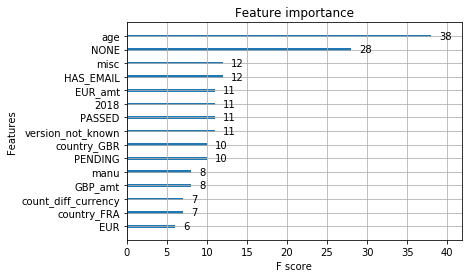

<Figure size 720x18000 with 0 Axes>

In [1013]:
# plot feature importance

plot_importance(bst_mod, importance_type='weight', max_num_features=15)
plt.figure(figsize=(10,250))
plt.show()

#### From the feature importance plot we can validate a few of our earlier hypothesis regarding features:

#### As expected Age emerged as most important feature.

#### Also a few engineered features Term_version, KYC category, EMAIL,spending in certain currency,no of currency used, few countries, entry_method etc. came within top 20 variables.

In [1328]:
feature_tab = pd.DataFrame(bst_mod.feature_importances_)
feature_tab['feature'] = train_X.columns
feature_tab.columns = ['importance_score','feature']
feature_tab.to_csv('feature_info.csv', index = False)
feature_tab.head(5)

,importance_score,feature
0,0.003610,count_diff_type
1,0.039711,2018_version
2,0.039711,PASSED
3,0.000000,count_diff_SOURCE
4,0.010830,HERA


### We load the feature importance table in our database for further reference  

In [1333]:
with open("D:/data_science/revolut_challenge/deliverables/misc/output_schemas.yaml") as schema_file:  #schema yaml for all Input tables
    config = yaml.load(schema_file)
create_tables(config, connection)
load_tables(config, connection,ip=False)

c:\users\sourish\anaconda3\lib\site-packages\ipykernel_launcher.py:2: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.



In [1334]:
#Let's try to access the database

try:
    cur = connection.cursor()
    cur.execute("""SELECT * FROM feature_information""") 
    rows = cur.fetchall()
    print('data reading')
except:
    print('data not read')
    
feature_info=pd.DataFrame(rows,columns=feature_tab.columns)
feature_info.head(3)

data reading


,importance_score,feature
0,0.003610,count_diff_type
1,0.039711,2018_version
2,0.039711,PASSED


#### feature importance table is loaded in our database

### Model Evaluation

#### As mentioned earlier unlike plain vanilla binary classification problem only here only accuracy can't be the evaluation metric. As with this extremely imbalanced classes, it’s easy to get a high accuracy without actually making useful predictions.

#### As this model will be used for relative ranking of users based on propensity to fraud AUC(AUC-Receiver Operating Characteristic) is one of the important Model Evaluation criteria, but not the only one. 

#### We need to achive a balance between Precision and recall(sensitivity), precisely f1 score for this problem.Let's first introduce two following concepts:

##### - Precision is about exactness, classifying only one instance correctly yields 100% precision, but a very low recall, it tells us how well the system identifies samples from a given class- here fraudsters.
  
  Precision = True fraudsters Captured by the model(TP)/(True fraudsters Captured by the model(TP) + True NonFraudsters falsly captured by the model(FP))
 
##### - Recall actually calculates how many of the Actual Positives(fraudsters) our model capture through labeling it as Positive (True Positive) .Applying the same understanding, we know that Recall shall be the one of the most important model metric here to evaluate our best model when there is a high cost associated with False Negative(Actual fraudstars not captured by the model).

  Recall = True fraudsters Captured by the model(TP)/(True fraudsters Captured by the model(TP) + True Fraudsters not captured by the model(FN))

#### Now it's upto the business context which is more expensive for the business- False Negative or False Positive.As the above two metrics work as opposing force,to get a balance between Precision and Recall F1 Score- harmonic mean of Precision and Recall might be one of the rational Model Evaluation metric here. However with this small data and with time constraint it's a difficult task to achieve.
  
  F1 = 2 X (Precision * Recall)/(Precision + Recall

AUC: 0.757


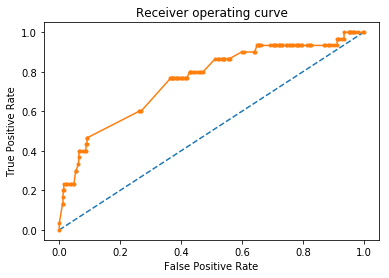

In [1001]:
y_score = bst_mod.predict_proba(valid_X)
fpr, tpr, thresholds = roc_curve(valid_Y.values, y_score[:,1])
auc = roc_auc_score(valid_Y.values, y_score[:,1])
print('AUC: %.3f' % auc)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating curve')
# show the plot
plt.show()

#### We already achieved a decent AUC score with small data, that means model can risk rank the users well 

#### Now we will see all the evaluation metric. We will also see Precision-Recall curve, which summarizes the trade-off between the true positive rate and the positive predictive value for this model.

Confusion Matrix :
[[677  68]
 [ 17  13]]
Accuracy Score : 0.8903225806451613
Report : 
              precision    recall  f1-score   support

           0       0.98      0.91      0.94       745
           1       0.16      0.43      0.23        30

    accuracy                           0.89       775
   macro avg       0.57      0.67      0.59       775
weighted avg       0.94      0.89      0.91       775

f1=0.234 auc=0.757


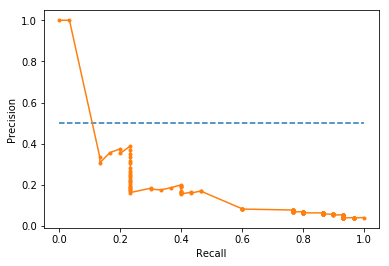

In [1014]:
#Classification report

y_pred = bst_mod.predict(valid_X)
results = confusion_matrix(valid_Y.values, y_pred) 
print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',accuracy_score(valid_Y.values, y_pred) )
print('Report : ')
print(classification_report(valid_Y.values, y_pred)) 
precision, recall, thresholds = precision_recall_curve(valid_Y.values, y_score[:,1])
auc = roc_auc_score(valid_Y.values, y_score[:,1])
f1 = f1_score(valid_Y.values, y_pred)
print('f1=%.3f auc=%.3f' % (f1,auc))
# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the plot
plt.show()

#### Although the model accuracy deteriorates a bit, model can detect 13(43%) of True fraudsters and 91% non-fraudsters are unaffected(from falsely labelled as fraudsters) and even with this small data we achieved a moderate f1 score. Later during operationalization with thresholding method we will try to reduce the error.  

### Operationalization and final output data to the business

#### As first step we need to rank the users based on propensity to fraud score(model predicted probability).This is relative grading. 

In [1025]:
#Grading

out_put = pd.concat([user_valid],axis=1)
out_put['IS_FRAUDSTER'] = valid_Y.values
out_put['model_score'] = y_score[:,1]
out_put.head(5)

,USER_ID,IS_FRAUDSTER,model_score
127,0393841d-7973-4469-91fd-db826f52c9af,0,0.414933
1930,3eabf957-f243-449f-9c07-7ab5383cf2f3,0,0.473206
3537,74c0a721-f585-4b2f-bf12-e7023d342755,0,0.508703
5710,bdf45de9-bac0-4fec-a195-0584db5eec7d,0,0.496553
3711,79e23af0-71fd-4e5a-9f27-76fd330a4857,0,0.425398


#### Then we will create 20 equal buckets(ventile) based on descending order of scores and to accommodate each user into respective bucket.

In [1219]:
out_put.sort_values('model_score',ascending=False,inplace=True)
out_put['ventile'] = pd.qcut(out_put['model_score'].rank(method = 'first'),20,labels=range(20,0,-1))

### Further model evaluation(Score grading/Risk ranking)

#### One of the important model utility criteria is how the mean model scores are graded across the top to bottom ventile. In our case the average fraud scores should monotonically decreasing from 1st to 20th ventile.

,model_score,ventile,cnt_fraudstar
19,0.602305,1,7
18,0.516216,2,5
17,0.497043,3,3
16,0.496553,4,2
15,0.496553,5,1


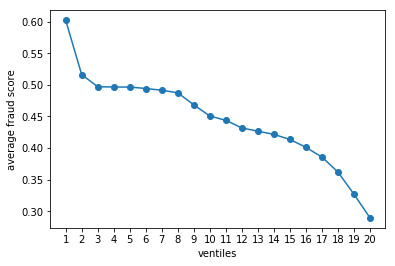

In [1114]:
ventiles = pd.pivot_table(out_put,index=['ventiles'],values=['model_score'],aggfunc=np.mean).reset_index(drop = True)
ventiles['ventile'] = range(20,0,-1)
ventiles['cnt_fraudstar'] = list(np.array(pd.pivot_table(out_put,index=['ventiles'],values=['IS_FRAUDSTER'],aggfunc=np.sum).reset_index(drop = True)['IS_FRAUDSTER']))
ventiles.sort_values('ventile',ascending=True,inplace=True)
display(ventiles.head(5))
plt.plot(range(len(ventiles)), ventiles['model_score'], 'o-')
plt.xticks(range(len(ventiles)),ventiles['ventile'])
plt.xlabel('ventiles')
plt.ylabel('average fraud score')
plt.show()

#### We got a perfect ranking curve

### Further Action(patroling)

#### Now as a live model there is a need for real time action-  to derive labelling(LOCK_USER, ALERT,Active ect.), based on user,transaction,country,currency etc. characteristics, at the time when the the user is actually transacting with the intention of making fraud. We need to follow the entire process of data preparation in the user level, call the model object(api),score it in real time on the batch/minibatch(or stochastic fashion) data of users.After calculation of propensity to fraud score, suitable thresholding criteria is used to label the respective users.  

#### First we calculate mean,min and max scores for each decile.

In [1154]:
#Fraudstar Capture rate

ventiles['cum_fraud_percent'] = np.cumsum(ventiles['cnt_fraudstar']/np.sum(ventiles['cnt_fraudstar']))
ventiles['min_score'] = pd.pivot_table(out_put,index=['ventiles'],values=['model_score'],aggfunc=np.min).reset_index(drop = True)
ventiles['max_score'] = pd.pivot_table(out_put,index=['ventiles'],values=['model_score'],aggfunc=np.max).reset_index(drop = True)
ventiles.head(4)

,model_score,ventile,cnt_fraudstar,cum_fraud_percent,min_score,max_score
19,0.602305,1,7,0.233333,0.537344,0.645749
18,0.516216,2,5,0.400000,0.503608,0.535840
17,0.497043,3,3,0.500000,0.496553,0.503608
16,0.496553,4,2,0.566667,0.496553,0.496553


#### For time constraint we devise a simple approch here as follows:

##### - to identify any users as FRAUDSTER and action as 'locked', who are in top 3 ventiles
##### - to identify any users needs to be monitored and action as 'alart', who are in 4th ventiles
##### - The rest of the users action will 'active'

##### - This just for illustration purpose In real time application we don't have the labelling  

In [1225]:
v = np.array(out_put['model_score'])
out_put['action'] = ['locked' if v[i] > ventiles['min_score'][17] else 'alart' if v[i] == ventiles['min_score'][17] else 'active' for i in range(len(v))]
out_put = shuffle(out_put)
display(out_put.head(5))
out_put.to_csv('output_score_action.csv',index=False)

,USER_ID,IS_FRAUDSTER,model_score,ventiles,action
5833,c2242523-6f0b-4beb-ae25-9efb2f384e13,0,0.425398,13,active
3737,7acabc49-dfd4-4ccb-b310-4d96c3cdf01a,0,0.419889,14,active
758,17a2e252-fec3-4ad4-954b-63bb28171e7b,0,0.496553,3,alart
3586,76037a7d-f3de-4ee8-8001-f68498251a53,0,0.441262,11,active
6690,defff5d9-e730-45b6-90a3-3e34c077cc7a,0,0.491458,7,active


#### I wrote a comprehensive patrol function and a python script, which can take care all the above steps.

#### With is approach cumulatively we can detect ~ 57% of true fraudstars

#### Creating output table at database and loading the userwise predicted score-action output data to database for business use.

In [ ]:
with open("D:/data_science/revolut_challenge/deliverables/misc/output_schemas.yaml") as schema_file:  #schema yaml for all Input tables
    config = yaml.load(schema_file)
create_tables(config, connection)
load_tables(config, connection,ip=True)

In [1255]:
#Let's try to access the database

try:
    cur = connection.cursor()
    cur.execute("""SELECT * FROM output_score_action_file""") 
    rows = cur.fetchall()
    print('data reading')
except:
    print('data not read')
    
user_score_action=pd.DataFrame(rows,columns=out_put.columns)
user_score_action.head(3)

data reading


,USER_ID,IS_FRAUDSTER,model_score,ventiles,action
0,c2242523-6f0b-4beb-ae25-9efb2f384e13,0,0.425398,13,active
1,7acabc49-dfd4-4ccb-b310-4d96c3cdf01a,0,0.419889,14,active
2,17a2e252-fec3-4ad4-954b-63bb28171e7b,0,0.496553,3,alart


#### Database access by the business user is successful

### Further improvement(For sake of time I left these options, however worth trying)

###### A)  Build predictive models using other unsupervised(anomaly detection algorithms,Isolation Forest etc.) supervised ML techniques like RF,SVM,GBM etc and compare the performance

###### B) Model Stacking: To improve the accuracy further we can take ensemble of models approach, in which can take simple of weighted(weight defined by normal logistic regression model)scores, as final prediction scores and then find the class for which prediction score is maximum.

##### C) Trying with other imbalance class handling strategies and threshold optimization.

###### D) More Feature Engineering.

##                   Thank You! Any Question